In [161]:
import skysurvey
import matplotlib.pyplot as plt
import numpy as np
import sncosmo
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import corner
import pandas


# skysurvey tests

In [71]:
snia = skysurvey.SNeIa()

In [72]:
data = snia.draw(size=10_000, inplace=True)

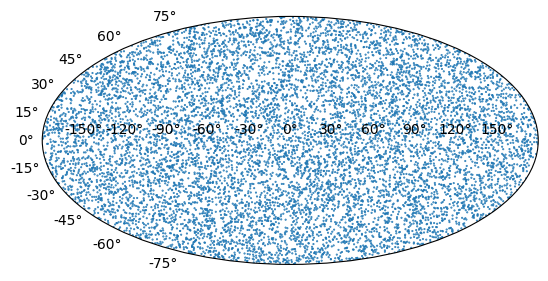

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (snia.data["ra"] - 360 * (snia.data["ra"] > 180)) * np.pi / 180,
    snia.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

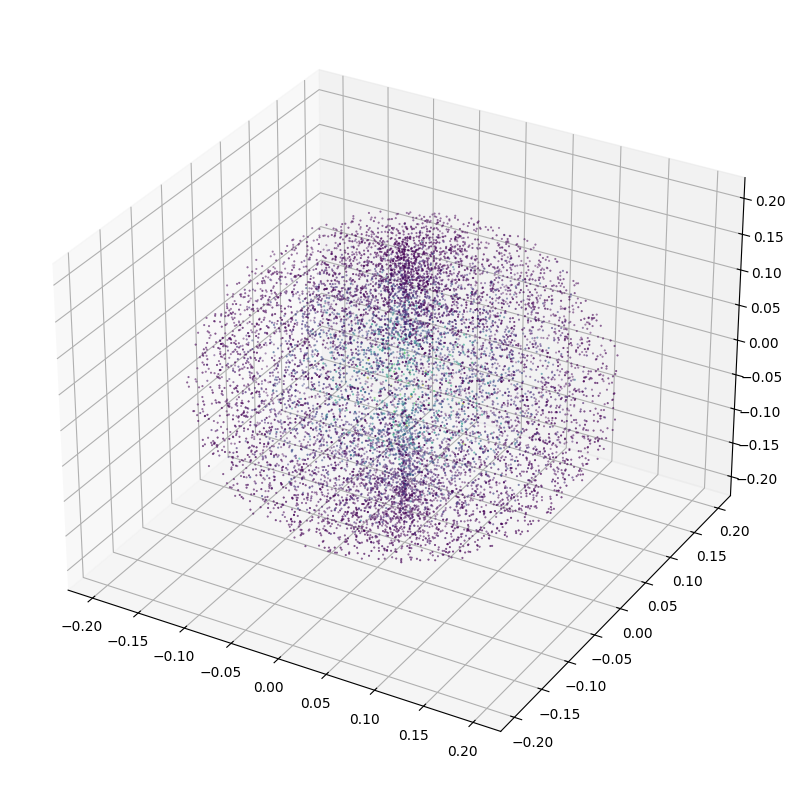

In [74]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))

count, bin = np.histogramdd([snia.data["ra"], snia.data["dec"], snia.data["z"]], bins=50)
count = gaussian_filter(count, 0.9)
binra, bindec, binz = bin
x, y, z = np.meshgrid(
    (binra[:-1] + binra[1:]) / 2 - binra.min(),
    (bindec[:-1] + bindec[1:]) / 2 - bindec.min(),
    (binz[:-1] + binz[1:]) / 2 - binz.min(),
)
tree = cKDTree(np.dstack((x.flatten(), y.flatten(), z.flatten())).reshape(-1, 3))
pts = np.vstack(
    [snia.data["ra"] - binra.min(), snia.data["dec"] - bindec.min(), snia.data["z"] - binz.min()]
).T


def density_tree(
    pts: np.ndarray, tree: cKDTree, density: np.ndarray, k=1
) -> np.ndarray:
    dist_id, nn_id = tree.query(pts, k=k)
    try:
        density = np.average(density[nn_id], axis=1, weights=1 / dist_id)
    except np.AxisError:
        density = density[nn_id]
    return density


c = density_tree(
    pts, tree, np.transpose(count, axes=[1, 0, 2]).flatten()[::-1], k=1
)

ax.scatter(
    np.cos(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.sin(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.cos(snia.data["dec"]) * snia.data["z"],
    s=1,
    c=c,
    marker=".",
)

In [75]:
snia.data

,z,x1,c,t0,ra,dec,magabs,mwebv,magobs,x0,template
0,0.18175,-0.225,0.083110,56064.851562,317.824371,65.026382,-19.030756,0.484290,20.764885,0.000078,salt2
1,0.17925,-1.380,0.201920,56098.800781,139.947266,36.287029,-18.382141,0.019008,21.380213,0.000045,salt2
2,0.16005,-1.270,0.028360,56062.574219,4.673224,18.464323,-19.121078,0.058316,20.370218,0.000113,salt2
3,0.19905,-0.005,0.147392,56137.914062,338.019562,29.906340,-18.693027,0.091667,21.321978,0.000047,salt2
4,0.18965,-0.895,-0.006018,56162.367188,33.392090,67.987717,-19.199108,0.509524,20.699001,0.000083,salt2
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.19315,-2.685,0.110873,56070.277344,229.800323,43.644482,-18.620289,0.029347,21.321960,0.000047,salt2
9996,0.09795,1.225,0.176507,56160.089844,150.980011,-16.071131,-18.811413,0.064729,19.527880,0.000245,salt2
9997,0.10785,0.815,0.151884,56085.242188,308.334595,-28.677168,-19.168968,0.063574,19.393581,0.000277,salt2
9998,0.15085,-0.130,-0.144816,56187.742188,218.352158,31.209257,-19.843882,0.023882,19.506628,0.000250,salt2


Text(0.5, 0.98, 'Distribution des SN')

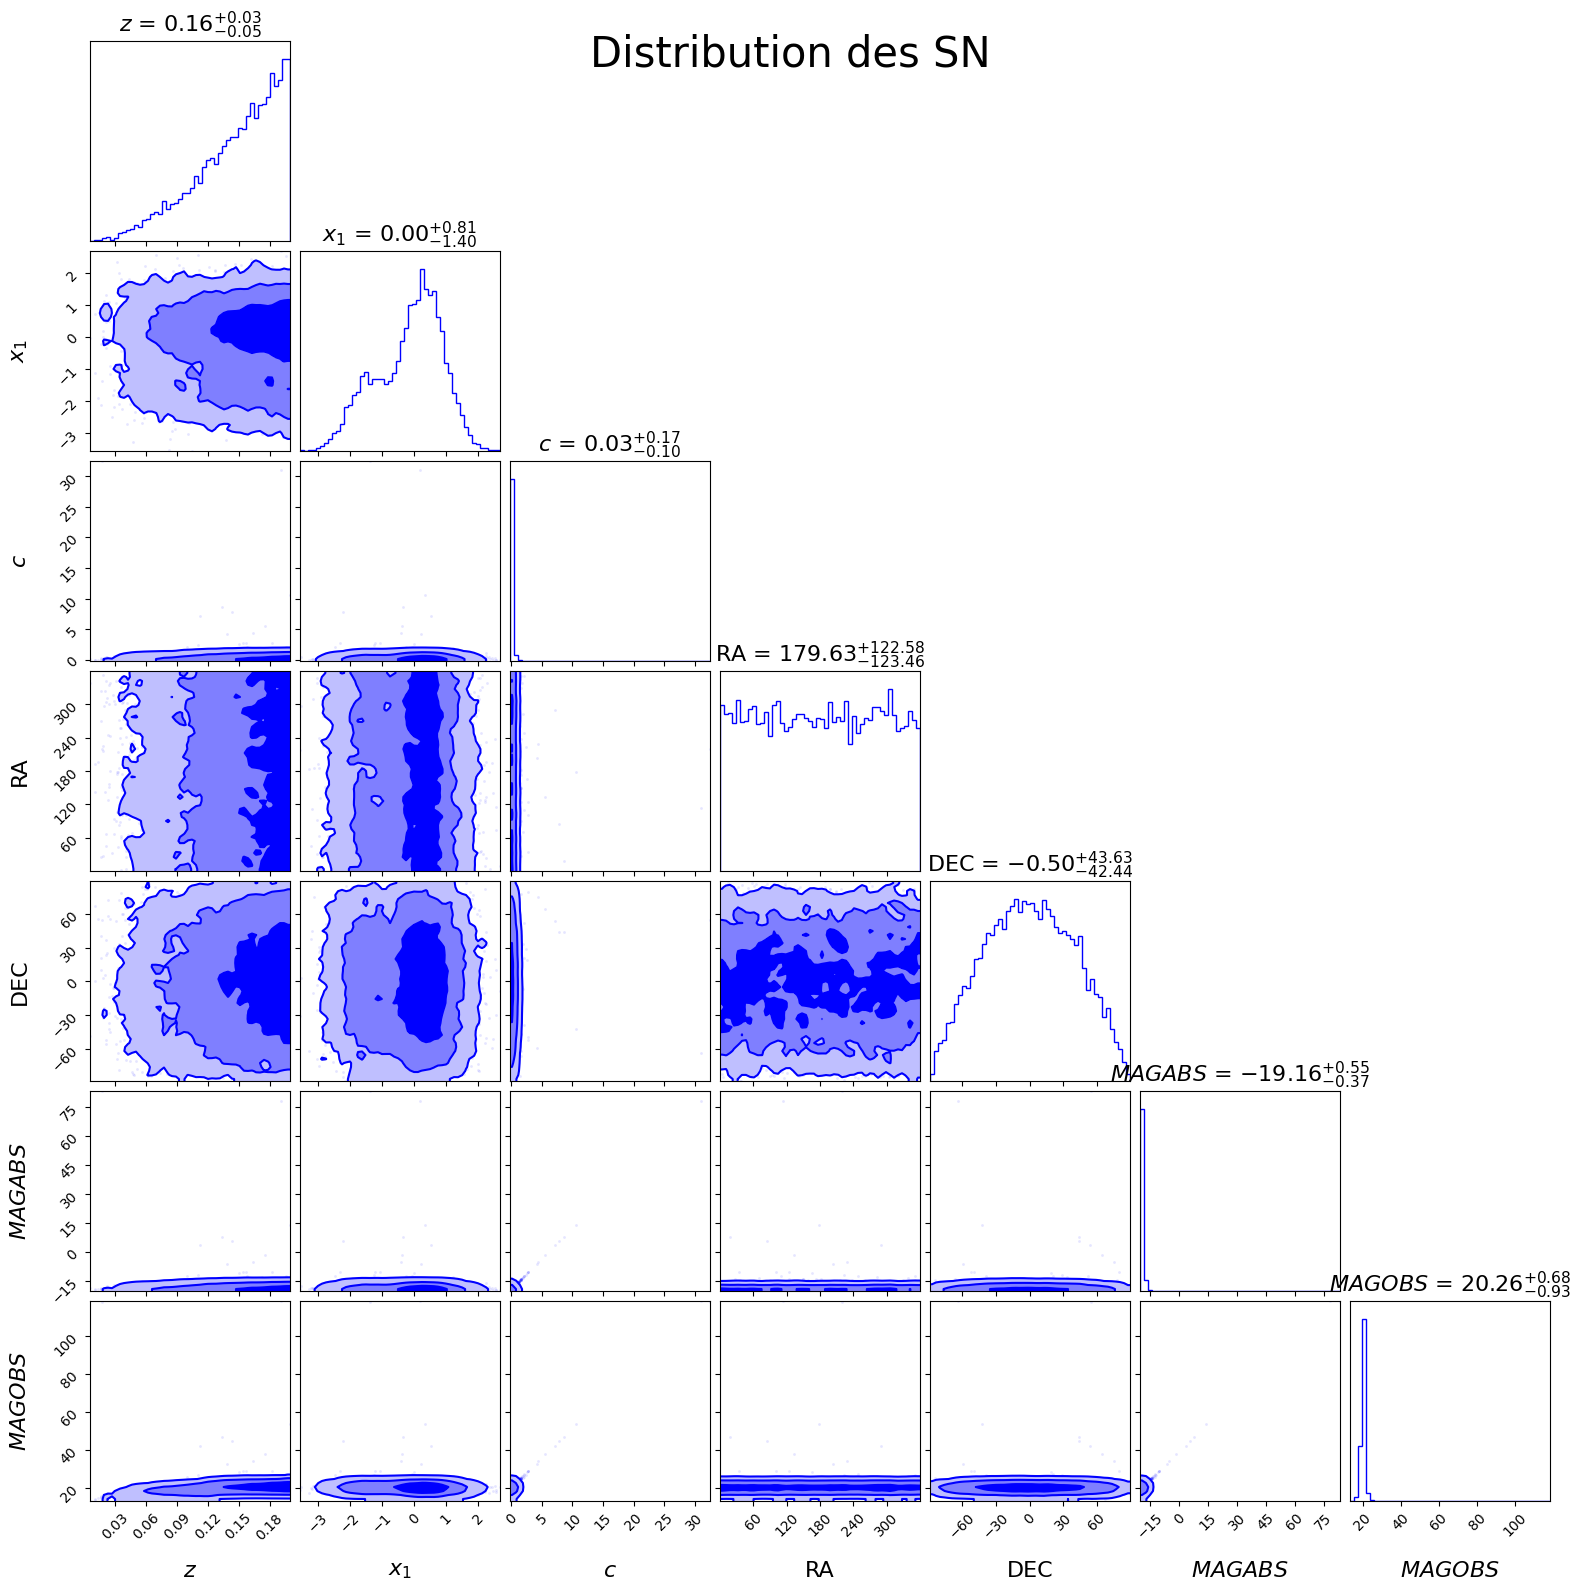

In [76]:
fig = corner.corner(
    snia.data,
    var_names=["z", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=50,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[r"$z$", r"$x_1$", r"$c$", r"RA", r"DEC", r"$MAGABS$", r"$MAGOBS$"],
    alpha=0.2,
)

fig.suptitle('Distribution des SN', fontsize=30)

In [77]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

In [78]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:751: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [128]:
dataset = dset.get_ndetection() > 5
detected = dataset[dataset].index

In [130]:
len(detected)

360

Text(0.5, 0.98, 'Distribution des SN détectées')

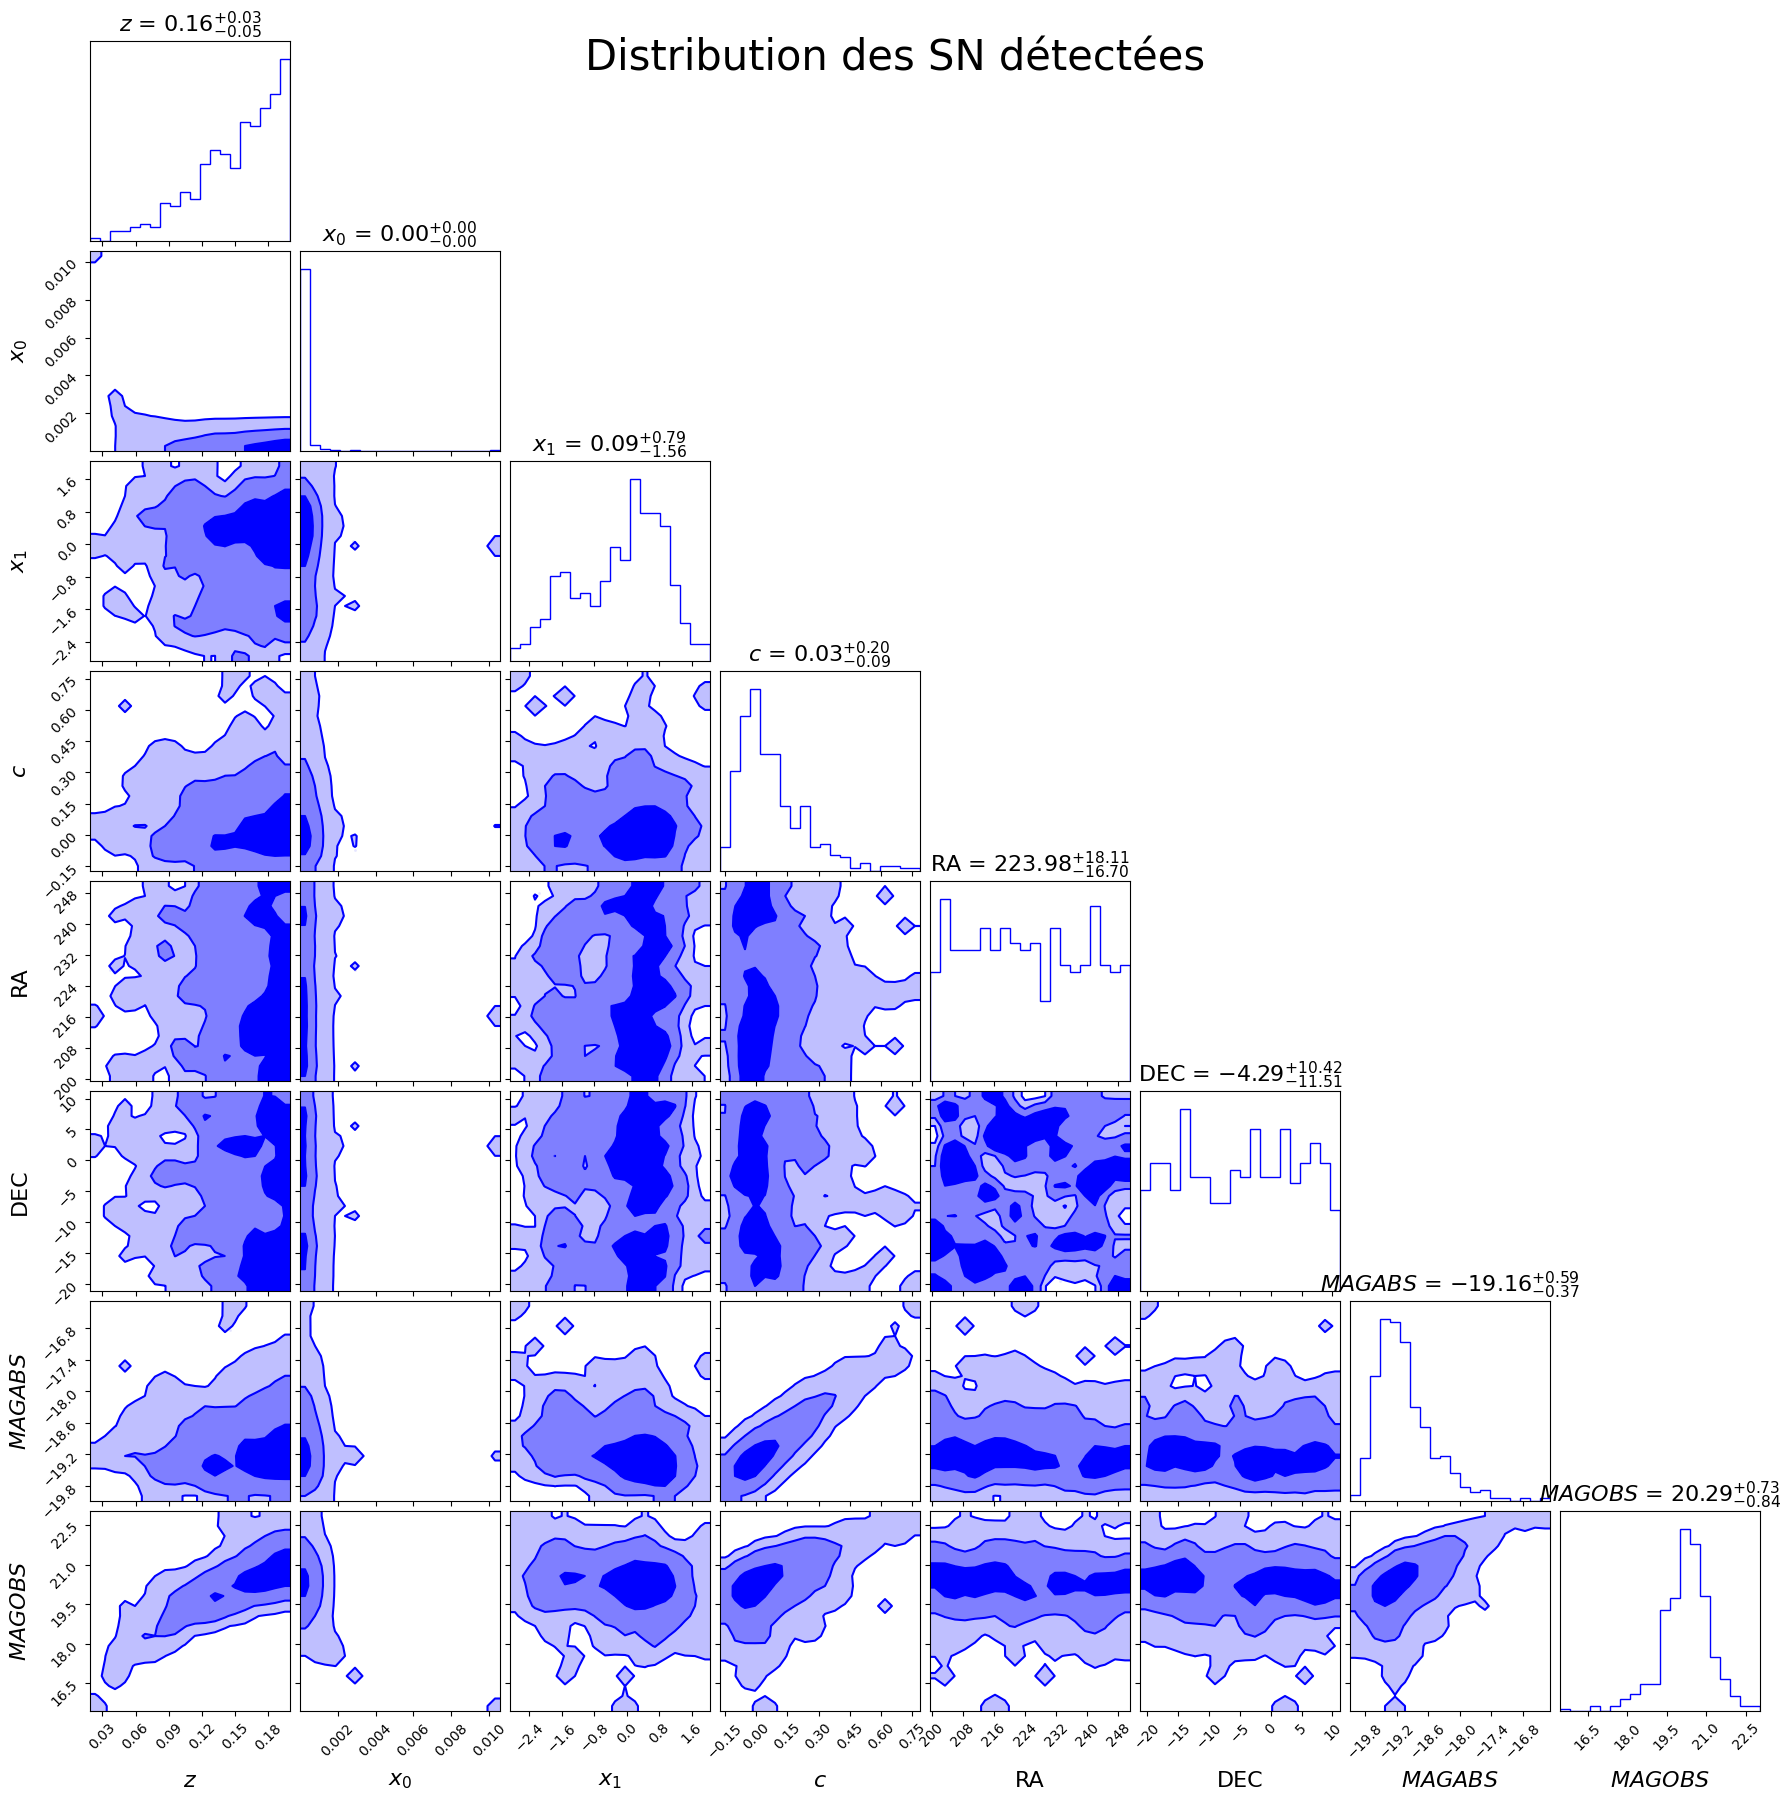

In [81]:
fig = corner.corner(
    dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=20,
    smooth=0.9,
    quantiles=None,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$MAGABS$",
        r"$MAGOBS$",
    ],
    alpha=0.2,
)
fig.suptitle('Distribution des SN détectées', fontsize=30)

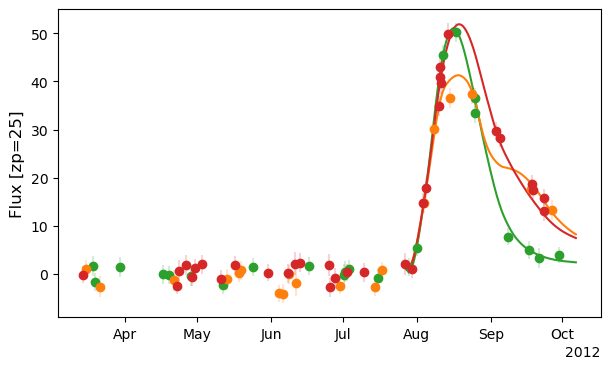

In [18]:
_ = dset.show_target_lightcurve(index=detected[212])

In [84]:
import warnings
from iminuit.warnings import IMinuitWarning
warnings.filterwarnings('ignore', category=IMinuitWarning) 

In [85]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

In [87]:
results

value     error        cov_t0        cov_x0        cov_x1  \
index                                                                        
61    z       0.165950       NaN           NaN           NaN           NaN   
      t0  56076.642355  0.000119  1.406037e-08 -8.320405e-15  3.406144e-10   
      x0      0.000141  0.000003 -8.320405e-15  8.518550e-12 -1.609167e-07   
      x1     -1.494876  0.173515  3.406144e-10 -1.609167e-07  3.012934e-02   
      c      -0.100651  0.016845  5.986491e-11 -4.064239e-08  7.499385e-04   
...                ...       ...           ...           ...           ...   
9976  z       0.175650       NaN           NaN           NaN           NaN   
      t0  56040.948513  0.020004  4.001741e-04  2.702059e-13 -1.271361e-08   
      x0      0.000044  0.000002  2.702059e-13  3.919417e-12 -2.269164e-07   
      x1     -0.518954  0.285869 -1.271361e-08 -2.269164e-07  8.186272e-02   
      c       0.366539  0.031626 -4.540617e-09 -5.675693e-08  2.304500e-03   

                 cov_c         truth  
index                                 
61    z            NaN       0.16595  
      t0  5.986491e-11  56075.347656  
      x0 -4.064239e-08       0.00014  
      x1  7.499385e-04         -1.77  
      c   2.838648e-04     -0.111124  
...                ...           ...  
9976  z            NaN       0.17565  
      t0 -4.540617e-09  56040.851562  
      x0 -5.675693e-08      0.000045  
      x1  2.304500e-03        -0.195  
      c   1.001014e-03      0.343443  

[1800 rows x 7 columns]

In [88]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)

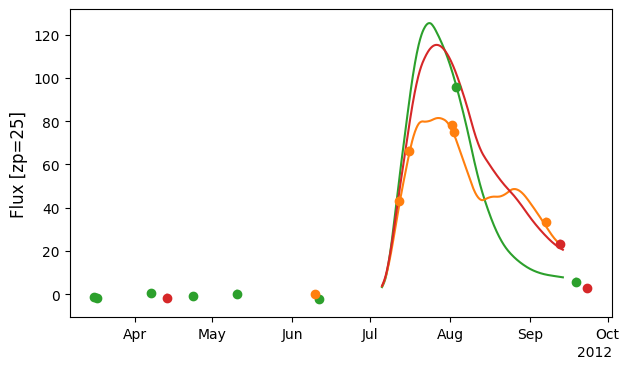

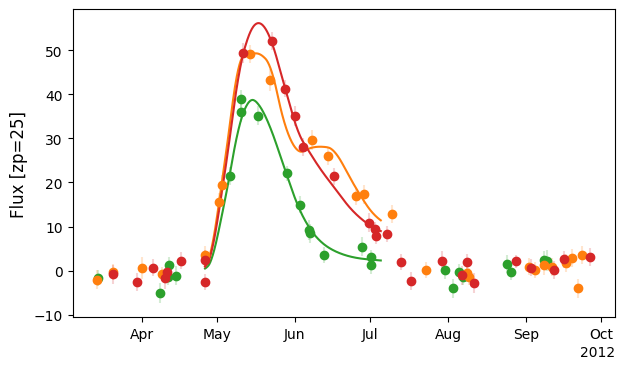

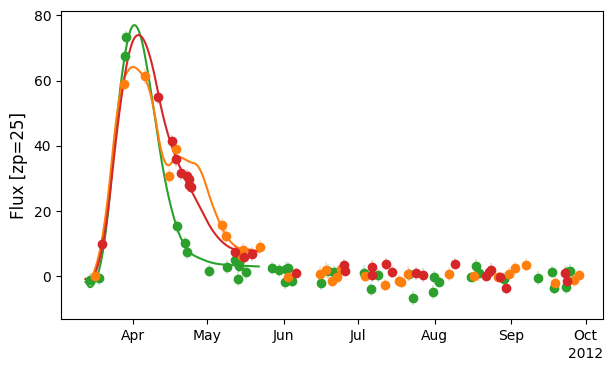

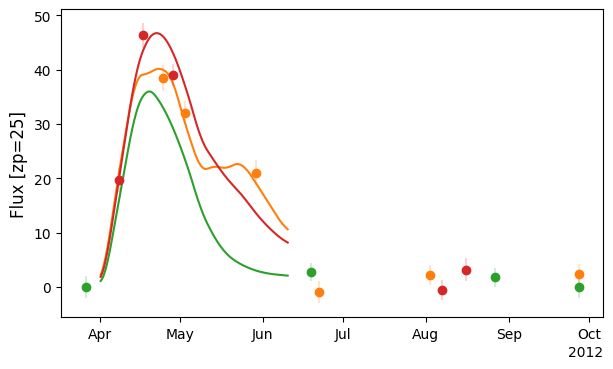

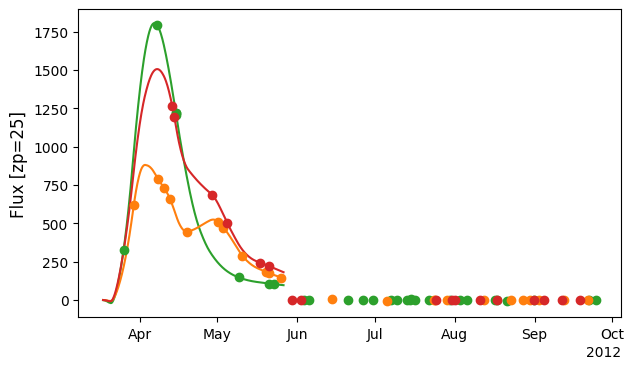

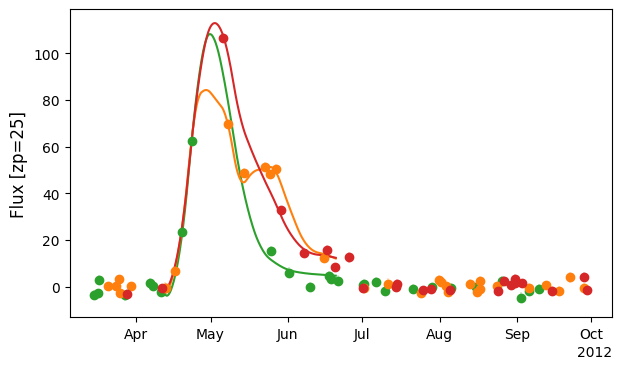

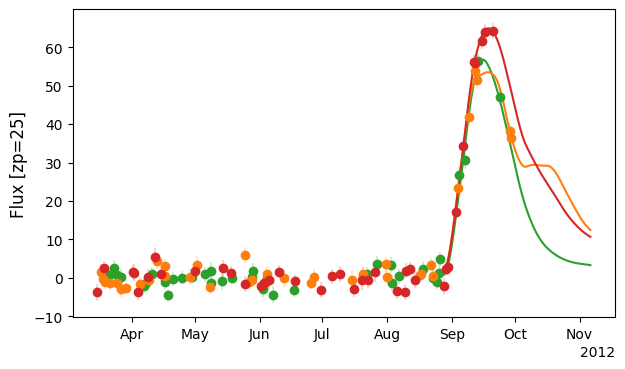

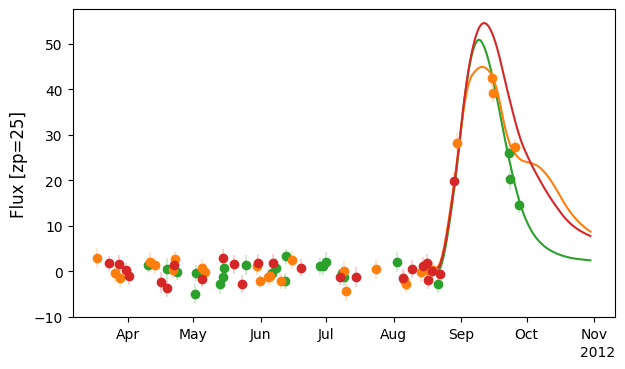

In [89]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].min()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].max()].index[0]])

Text(0.5, 0.98, 'Erreur absolue sur les paramètres reconstruits')

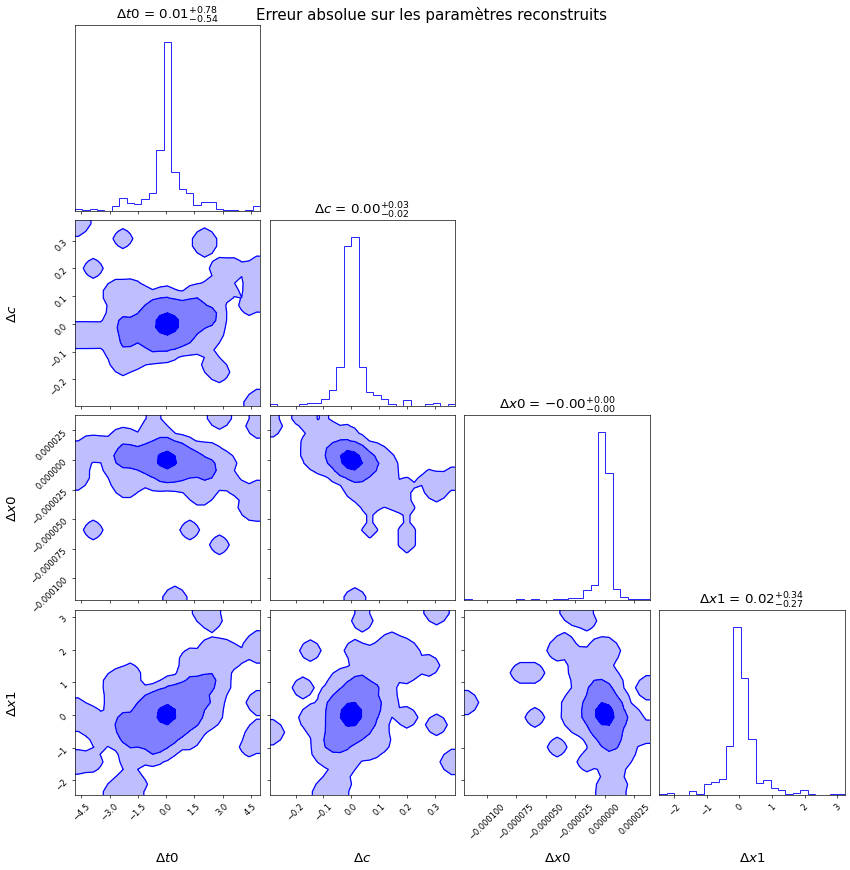

In [158]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner.corner(
    better_results,
    fig=fig,
    var_names=list(guess.keys()),
    show_titles=True,
    bins=25,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    alpha=0.2,
)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)

# Uchuu tests

In [118]:
import fitsio

path = "/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/Uchuu/LightCone/BGS_v2/"

data = fitsio.read(path+"BGS_LC_Uchuu.fits", columns=['RA', 'DEC', 'STATUS'])
ra  = np.float32(data['RA']) # RA (deg)
dec = np.float32(data['DEC']) # Dec (deg)
status = data['STATUS']

In [119]:
in_desi = status & 2**1 != 0 # in DESI footprint

In [120]:
np.sum(in_desi)

26090838

Text(0, 0.5, 'Dec (deg)')

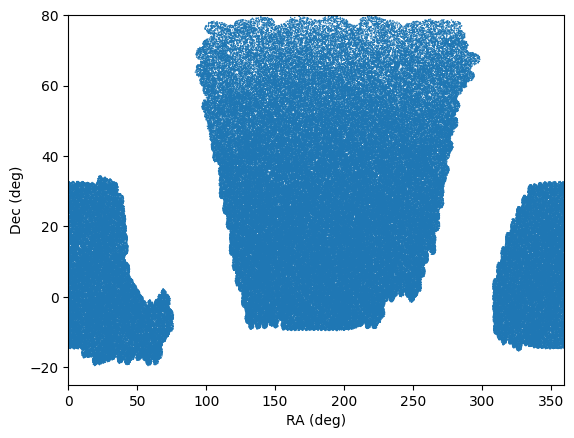

In [121]:
plt.figure()
plt.scatter(ra[in_desi][::100], dec[in_desi][::100], s=1, edgecolor="none")
plt.xlim(0,360)
plt.ylim(-25, 80)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")

In [122]:
snia = skysurvey.SNeIa()
data = snia.draw(size=10000, inplace=True)

In [123]:
data['ra'] = ra[in_desi][:10000]
data['dec'] = dec[in_desi][:10000]

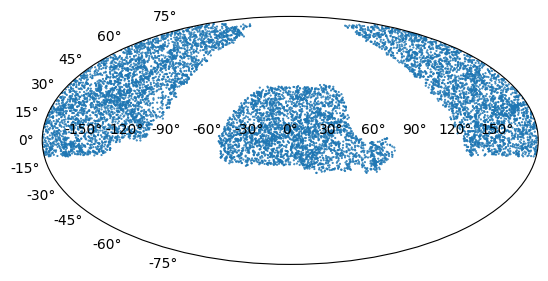

In [124]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (snia.data["ra"] - 360 * (snia.data["ra"] > 180)) * np.pi / 180,
    snia.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

In [126]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

In [131]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
dataset = dset.get_ndetection() > 5
detected = dataset[dataset].index

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:751: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [145]:
len(detected)

499

Text(0.5, 0.98, 'Distribution des SN détectées')

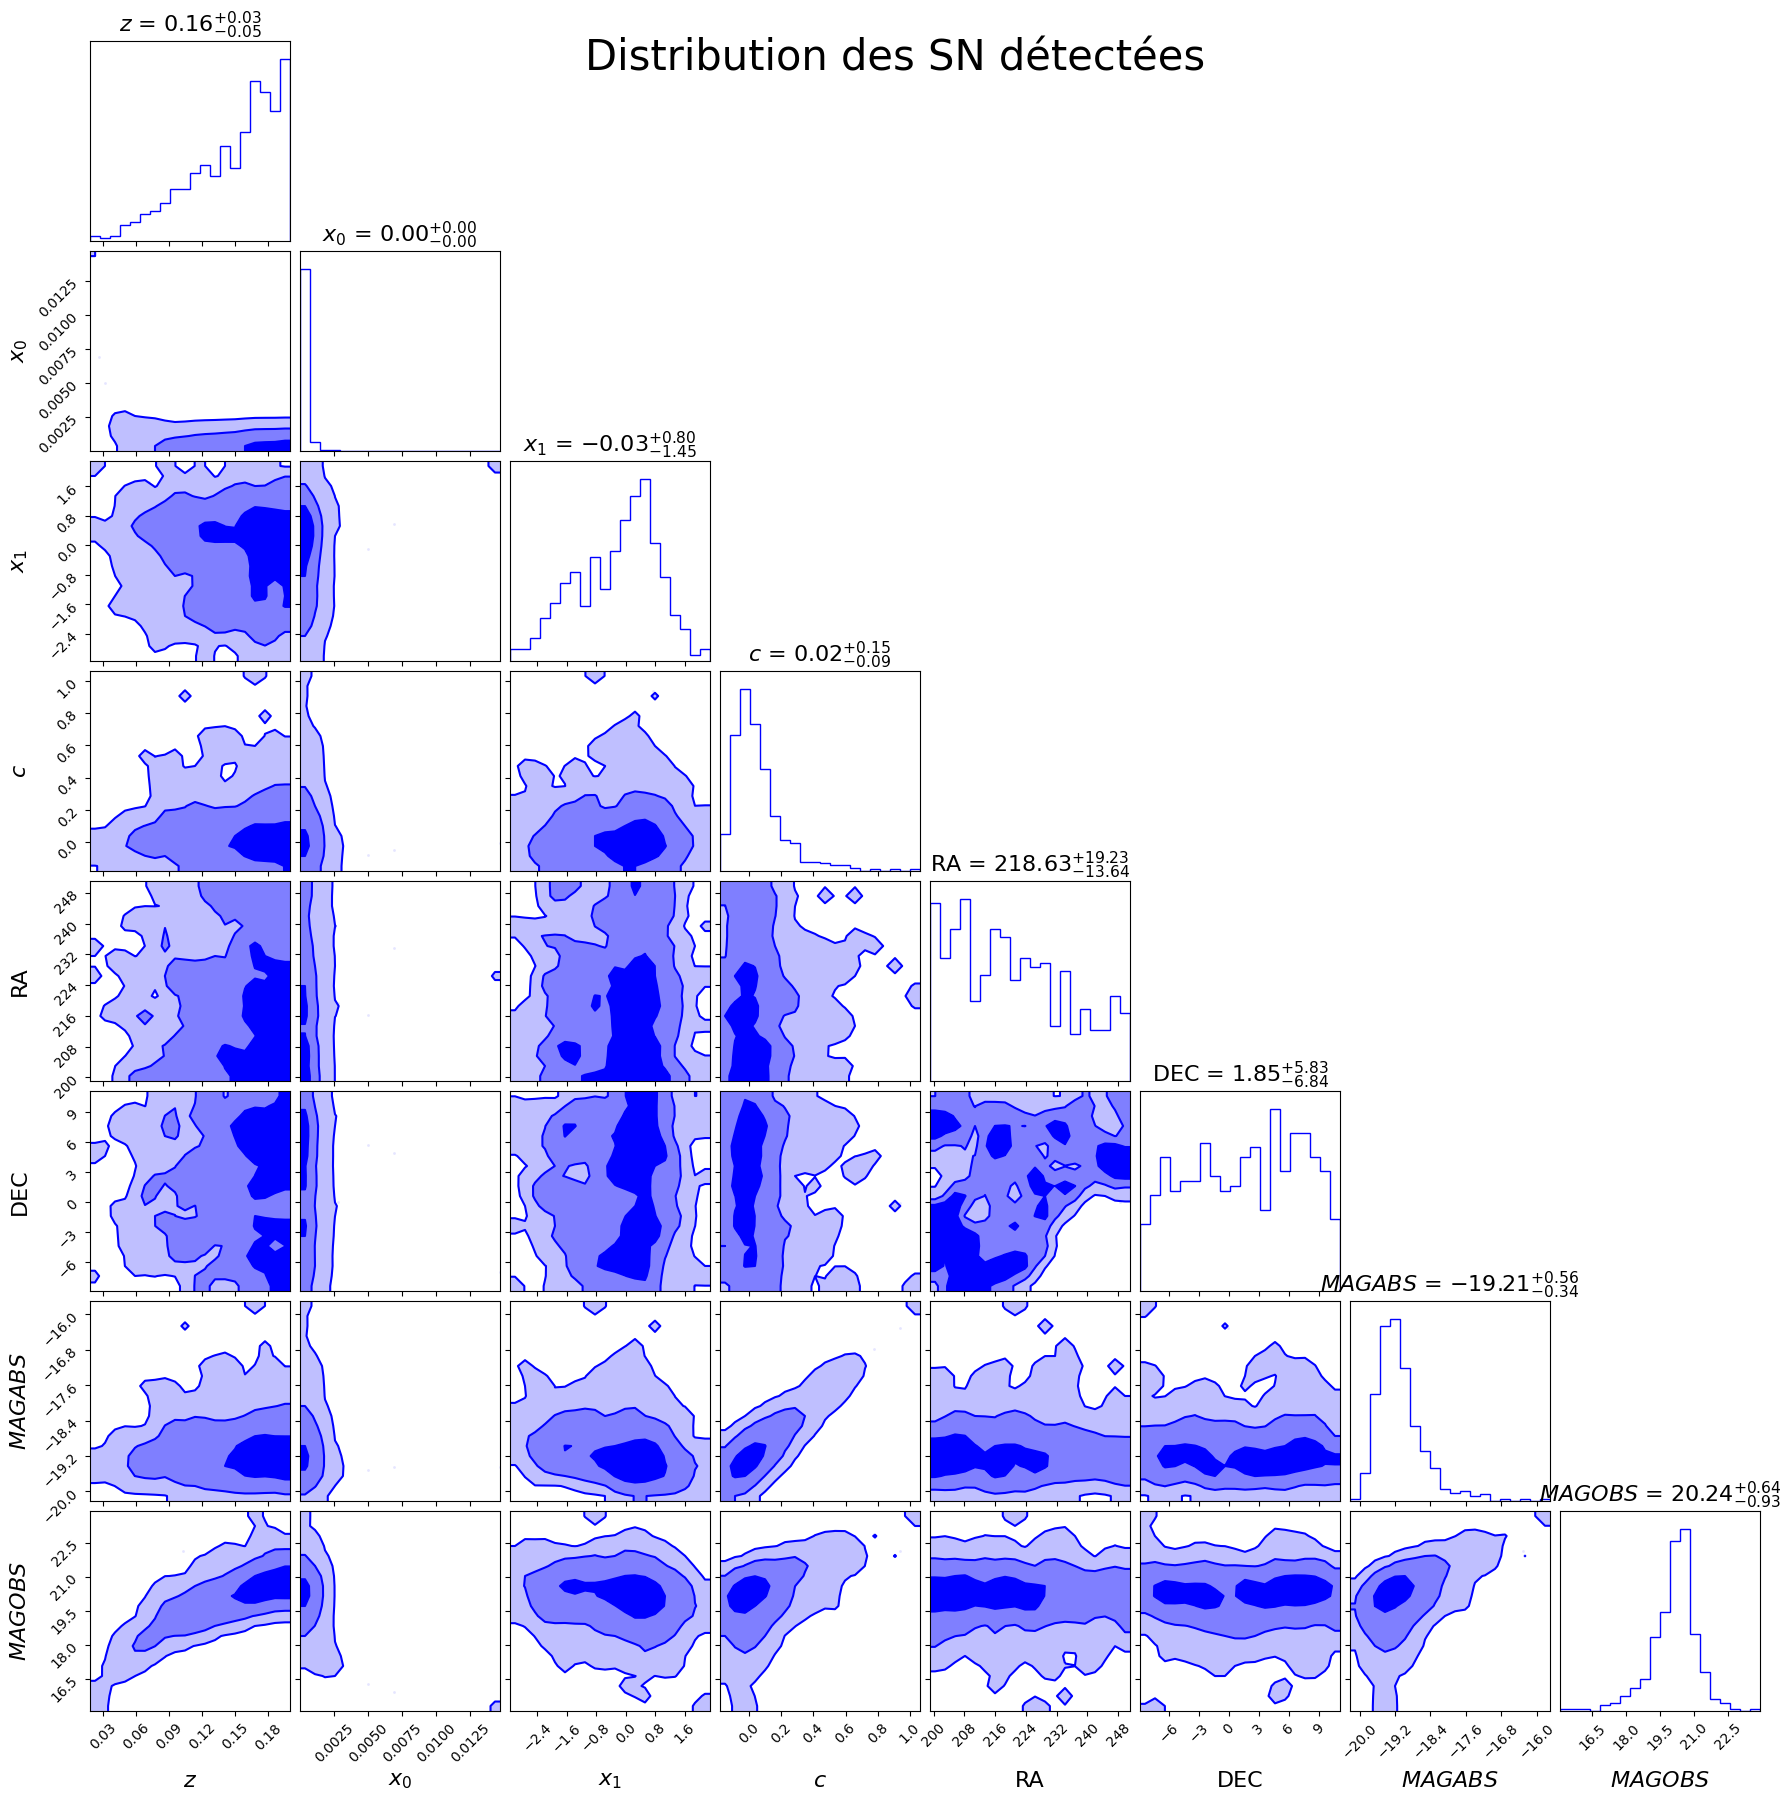

In [132]:
fig = corner.corner(
    dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=20,
    smooth=0.9,
    quantiles=None,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$MAGABS$",
        r"$MAGOBS$",
    ],
    alpha=0.2,
)
fig.suptitle('Distribution des SN détectées', fontsize=30)

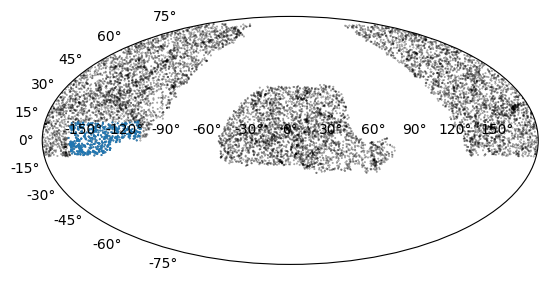

In [166]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (dset.targets.data["ra"] - 360 * (dset.targets.data["ra"] > 180)) * np.pi / 180,
    dset.targets.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=0.5,
    c='k',
    alpha=0.5,
)
ax.scatter(
    (dset.targets.data.loc[detected]["ra"] - 360 * (dset.targets.data.loc[detected]["ra"] > 180)) * np.pi / 180,
    dset.targets.data.loc[detected]["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)
plt.savefig("../../../project/figures/Uchuu_scatter.png")

In [144]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pandas.concat(results, keys=index)


In [146]:
results

value     error        cov_t0        cov_x0        cov_x1  \
index                                                                        
59    z       0.141750       NaN           NaN           NaN           NaN   
      t0  56186.768389  0.182088  3.317068e-02 -1.084386e-07  1.984857e-02   
      x0      0.000126  0.000002 -1.084386e-07  6.216856e-12 -3.638528e-07   
      x1      0.250709  0.256988  1.984857e-02 -3.638528e-07  6.613439e-02   
      c       0.106341  0.016373  7.526658e-04 -3.463928e-08  2.508430e-03   
...                ...       ...           ...           ...           ...   
9980  z       0.142250       NaN           NaN           NaN           NaN   
      t0  56033.900381  0.000007  4.652061e-11 -2.319310e-16  2.371289e-12   
      x0      0.000132  0.000002 -2.319310e-16  4.927052e-12 -2.011316e-07   
      x1      0.791631  0.136124  2.371289e-12 -2.011316e-07  1.853719e-02   
      c       0.126555  0.013345  2.025845e-12 -2.654280e-08  1.024039e-03   

                 cov_c         truth  
index                                 
59    z            NaN       0.14175  
      t0  7.526658e-04  56186.996094  
      x0 -3.463928e-08      0.000128  
      x1  2.508430e-03           0.5  
      c   2.681374e-04      0.095762  
...                ...           ...  
9980  z            NaN       0.14225  
      t0  2.025845e-12  56033.171875  
      x0 -2.654280e-08      0.000137  
      x1  1.024039e-03         0.665  
      c   1.781286e-04      0.097167  

[2495 rows x 7 columns]

In [162]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)
better_results

,t0,c,x0,x1
0,-0.227704,0.010579,-0.000002,-0.249291
1,-0.045117,0.012519,-0.000001,0.133592
2,0.116544,0.037261,-0.000004,0.190393
3,4.216993,0.206665,-0.000022,4.839088
4,0.255849,0.021016,-0.0,0.057687
...,...,...,...,...
494,4.973987,-0.03238,-0.000197,0.081994
495,-1.488056,-0.04305,0.000004,-0.465337
496,0.068838,0.020908,-0.000001,0.020546
497,-0.065807,0.002394,-0.000001,0.188052


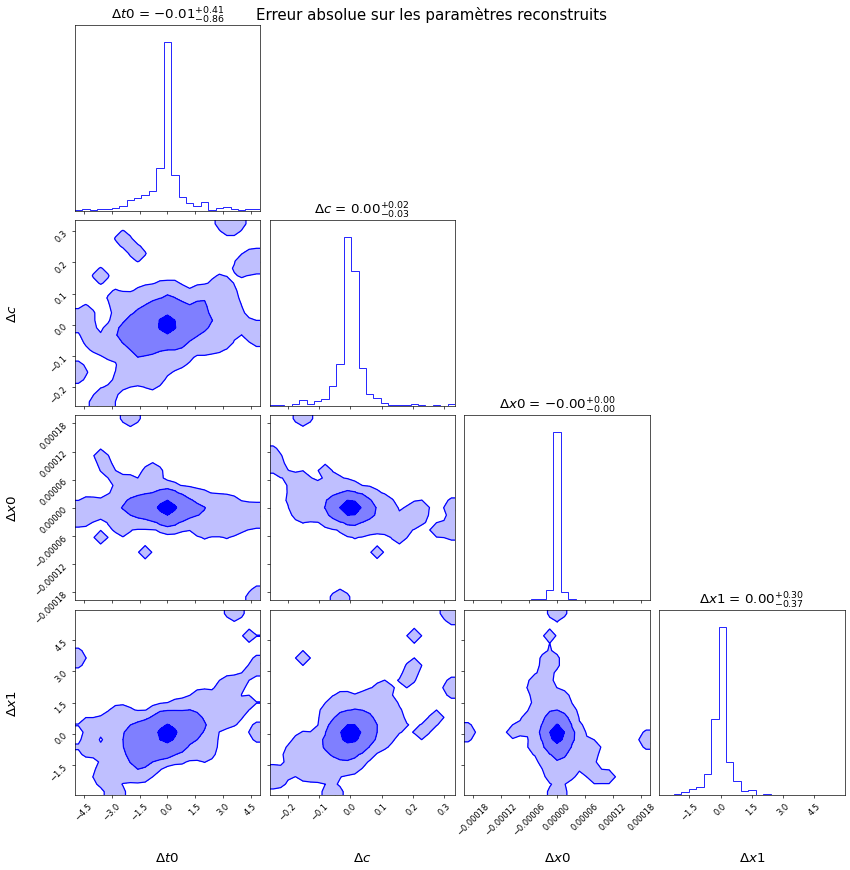

In [165]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner.corner(
    better_results,
    fig=fig,
    var_names=list(guess.keys()),
    show_titles=True,
    bins=25,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    alpha=0.2,
)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)
plt.savefig('../../../project/figures/Uchuu_reconstructed')